<a href="https://colab.research.google.com/github/omartinez182/Python-Interpreter/blob/master/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Eduardo Martinez"
COLLABORATORS = ""

---

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Assignment 1 Question 1: Classifying Digits
For this question we are going to be tackling an optical character recognition problem: identifying images of hand-written digits using a dataset called MNIST, which is immensely popular for use in introductory ML courses. I have provided you the model to use below (and at this point in the course you can treat it as a “black box”).  The objective of this problem is to identify the optimal value of a particular hyperparameter for the model by using the validation strategies we have learned in class.  

Please write your code directly into the notebook in the cells marked "YOUR CODE HERE".  Please DO NOT modify any other code cells.  After you have added your code, restart your kernel and run the notebook from the top to ensure all cells run properly.  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

In [3]:
# Load the dataset we will use
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

As we can see above, we have 1797 observations of hand-written digits, each with a shape of 8x8 pixels.  Let's now visualize some of them so we can understand better what they look like.

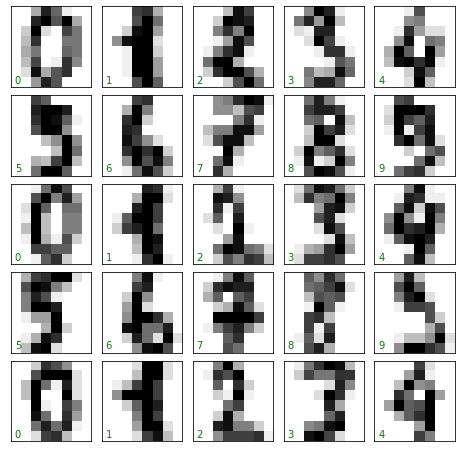

In [4]:
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

Above we can see 25 of the digit images, with the digit label shown in small green font at lower left.  In our modeling project, we will use the values of each pixel (64 in total per image: 8x8) as the features of our input to the model.  Our target will be the image labels indicating what digit the image represents.

As we know, to use the Scikit-Learn models our input data is expected to be in the shape [n_observations, n_features].  To get our input data into this form, we need to flatten our image pixel matrix from 8x8 to 1x64 (each row has 64 features - one feature representing each pixel).  Fortunately, someone has already done this for us and we can read the data in using the proper shape as shown below.

In [5]:
# Read in the input and target data
X = digits.data
y = digits.target
print(X.shape,y.shape)

(1797, 64) (1797,)


## Q1.1: Train and test a KNN classification model (10 pts)

In this part, we will practice training and evaluating performance of models using a simple K-Nearest-Neighbors (KNN) classifier model.  You do not need to worry about how this model works at this point, but if you are curious, for each datapoint that is fed to it to generate a prediction, it identifies the "*n_neighbors*" (a hyperparameter you can adjust) closest datapoints to it found in the training dataset (using either Euclidian distance or another similarity metric) and returns the target label most common to the *n_neighbors* neighbor points.  For example, if you feed an image to the KNN classifier and it identifies that most of the nearby points to the image are labeled as "3", it will predict that the image you have just provided is also a "3".

For this first part, I have provided the code to set up the model below.  What I would like you to do is to complete the function `model_digits()` which accepts as input the input data `X` and the target labels `y` defined above, a model `model`, a value for `random_state` and a value for percentage of data to use in the test set `test_size`.

The function should do the following:  
- Split the data (X and y) into a training and set set using 80% for the training set and 20% for the test set.  Be sure to set `random_state=0` when splitting the data  
- Fit your model using the training data  
- Get the predictions on the test set and calculate accuracy of the test set predictions

Your function should return the accuracy of the test set predictions.

In [6]:
def model_digits(X,y,model,random_state=0,test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=random_state, test_size=test_size)  # Split the data into train and test sets
    model.fit(X_train, y_train) # Fit the data (train) to the model
    preds = model.predict(X_test) # Generate predictions for the test set
    accuracy = sum(preds==y_test)/len(y_test) # Calculate accuracy
    return accuracy
    raise NotImplementedError()

In [7]:
# Test cell

# Set up the model we will use
knn_model = KNeighborsClassifier(n_neighbors=5)

# Apply your function
acc_test = model_digits(X,y,knn_model,random_state=0,test_size=0.2)
print('Accuracy of your classifier on the test set is {:.3f}'.format(acc_test))

# hidden tests below

Accuracy of your classifier on the test set is 0.975


## Q1.2: Perform algorithm selection using a validation set (20 pts)

In this part, we will compare performance of two different classifer algorithms: a KNN model as above and a multilayer perceptron (neural network) model.  We will not do any hyperparameter tuning for either model, but rather will focus on comparing the two algorithms as they are provided in the cell below.  Your task is to compare models using a fixed validation set (NOT cross-validation, yet).  

To do this, complete the below function `compare_models()` which takes as input the data `X` and labels `y` defined above, two models to compare `model1` and `model2`, the percentage of data to use for the test set `test_size`, and the percentage of the training set to use for validation `val_size`.

Your function should do the following:  
- Split your data into a test set and training set using the inputs `test_size` and `val_size`, being sure to use random_state=0 while splitting.  
- Further split your training set into a validation set and training subset, being sure to use `random_state=0` while splitting.  
- Fit each model on the training set  
- Get the predictions of each model on the validation set and calculate the validation accuracy. 
- Select the model with the higher validation accuracy as your final model. 
- Retrain your final selected model on the training+validation set
- Using your retrained final model, calculate the predictions on the test set and the accuracy of the test set predictions. 

Your function should return the test set accuracy performance of your selected model.

In [8]:
def compare_models(X,y,model1,model2,test_size,val_size,random_state=0):
    # Split data into train, validation, and test sets
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, random_state=random_state, test_size=val_size)

    # Fit data (train) to the models
    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)

    # Generate predictions for the validation set
    preds_model1 = model1.predict(X_val)
    preds_model2 = model2.predict(X_val)

    # Calculate accuracy for each model
    val_acc_model1 = sum(preds_model1==y_val)/len(y_val)
    val_acc_model2 = sum(preds_model2==y_val)/len(y_val)

    # Select and retrain the best model on the full training set and calculate accuracy
    if val_acc_model1 < val_acc_model2:
      model2.fit(X_train_full, y_train_full)
      val_preds = model2.predict(X_test)
      val_acc = sum(val_preds==y_test)/len(y_test)
    else:
      model1.fit(X_train_full, y_train_full)
      val_preds = model1.predict(X_test)
      val_acc = sum(val_preds==y_test)/len(y_test)
    
    return val_acc
    raise NotImplementedError()

In [9]:
# Test cell

# Set up the two models to compare
model_knn = KNeighborsClassifier(n_neighbors=5)
model_mlp = MLPClassifier(hidden_layer_sizes=(100,50),activation='relu',
                      solver='sgd',learning_rate_init=0.01,max_iter=2000)

testacc = compare_models(X,y,model_knn,model_mlp,test_size=0.2,val_size=0.3,random_state=0)
print('Accuracy of your final model on the test set is {:.3f}'.format(testacc))

# Hidden tests

Accuracy of your final model on the test set is 0.975


## Q1.3: Tune hyperparameters using cross-validation (20 pts)

For this part, we are again going to use the KNN algorithm which we used above.  However, rather than leaving its hyperparameter *n_neighbors* at a fixed value, we are going to run it with different values and determine which value gives us the best performance.  We will then use that in our final model.  To compare versions of the model using different values of *n_neighbors* we will use cross-validation.

Your objective is the find the optimal value of `n_neighbors` using cross-validation and then to evaluate the performance of your best model.  To do this, complete the below function `crossval_compare()` which takes as input the data `X` and labels `y`, a range of values `n_range` to try for the hyperparameter `n_neighbors` of the model, the number of iterations `k` to use in the cross-validation, the amount of data to reserve for the test set `test_size`, and `random_state=0`.  

Your function should perform the following:  
- Split the data into training and test sets (be sure to set `random_state=0`. 
- For each integer value `n` in `n_range`:
    - Instantiate a KNeighborsClassifier model setting `n_neighbors = n`  
    - Perform a K-folds cross-validation, training the model on the training folds then evaluating the accuracy of the model on the validation fold
    - Calculate and store the mean validation accuracy
- Identify the value of `n_neighbors` which yielded the highest mean validation accuracy  
- Create a final KNeighborsClassifier model using the optimal `n_neighbors` value from above. 
- Fit your final model and then use it to get the predictions for the test set. 
- Calculate the accuracy of your final model on the test set

Your function should return a tuple of the optimal value of `n_neighbors` from the range as an integer, and the accuracy of your final optimal model on the test set as a float.

In [10]:
def crossval_compare(X,y,n_range,k,test_size,random_state=0):
    # Split data into traing and test sets
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X,y, test_size=test_size, random_state=random_state)

    # Empty list to store the mean accuracy values of each model
    mean_accuracy = []

    # Instantiate, fit, and calculate accuracy for len(n_range) models
    for n in n_range:
      knn_model = KNeighborsClassifier(n_neighbors=n) # Instantiate the KNN classifier
      kf = KFold(n_splits=k, random_state=random_state, shuffle=True) # KFolds object

      accuracy = [] # Empty list to store the accuracy value of each round

      # Train and evaluate models for each round of cross-validation
      for train_index, test_index in kf.split(X_train_full, y_train_full):
          X_train, X_test = X_train_full[train_index], X_train_full[test_index]
          y_train, y_test = y_train_full[train_index], y_train_full[test_index]
          knn_model.fit(X_train, y_train)
          preds = knn_model.predict(X_test)
          accuracy.append(sum(preds==y_test)/len(y_test))

      # Store the mean accuracy value of each model
      mean_accuracy.append(np.mean(accuracy))

    # Train and evaluate model with the best parameter
    index_best_model=np.argmax(mean_accuracy) # Select the index of the model with the highest accuracy
    final_knn = KNeighborsClassifier(n_neighbors=n_range[index_best_model]) # Use the best parameter
    final_knn.fit(X_train_full, y_train_full)
    final_preds = final_knn.predict(X_test_full)
    final_accuracy = sum(final_preds==y_test_full)/len(y_test_full)

    return (n_range[index_best_model], final_accuracy)
    raise NotImplementedError()

In [11]:
# Test cell
n_range = [5,30]
k=5
opt_n, testacc = crossval_compare(X,y,n_range,k,test_size=0.2,random_state=0)
print('Your function found the optimal value of n_neighbors to be {}'.format(opt_n))
print('Your function calculated the accuracy of your final model as {:.3f}'.format(testacc))

# Hidden tests

Your function found the optimal value of n_neighbors to be 5
Your function calculated the accuracy of your final model as 0.975
